In [ ]:
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import Command, Interrupt
from langgraph.prebuilt import ToolNode,tools_condition,create_react_agent
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import uuid
import os
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
check=MemorySaver()

In [3]:
model=ChatGoogleGenerativeAI(api_key=os.getenv('google'),model='gemini-2.5-flash')

In [4]:
class lINKDIN(TypedDict):
    topic:str
    post:Annotated[list[str],add_messages]
    feedback:Annotated[list[str],add_messages]

In [5]:
graph=StateGraph(lINKDIN)

In [6]:
def generate_post(state:lINKDIN)->lINKDIN['post']:
    topic=state['topic']
    feedback=state['feedback'] if 'human_feedback' in state['feedback'] else ['no_feedback_yet']

    prompt=[SystemMessage(content='you are a professional linkdin post creator'),
            HumanMessage(content=f"""LinkedIn Topic: {topic}
         Human Feedback: {feedback[-1] if feedback else "No feedback yet"}
        Generate a structured and well-written LinkedIn post based on the given topic.
         Consider previous human feedback to refine the reponse.""")
    ]
    content=model.invoke(prompt).content
    
    print(f"the generated post is {content}")

    return {'post':content,'feedback':feedback}

In [7]:
def human(state:lINKDIN)->lINKDIN['feedback']:
     generated_post = state["post"]

     human_input=Interrupt(f"Please provide your feedback on the generated LinkedIn post:{generated_post}")

     print(f"[human_node] Received human feedback: {human_input}")

     if human_input=='dpne':
          return Command(update={"feedback": state["feedback"] + ["Finalised"]}, goto="end_node")

     return Command(update={'feedback': state["feedback"] + [human_input]}, goto="generate_post_")

In [8]:

def end_node(state: lINKDIN): 
    """ Final node """
    print("\n[end_node] Process finished")
    print("Final Generated Post:", state["post"][-1])
    print("Final Human Feedback", state["feedback"])
    return {"generated_post": state["post"], "human_feedback": state["feedback"]}

In [9]:
graph.add_node("generate_post", generate_post)
graph.add_node("human", human) 
graph.add_node("end_node", end_node)
graph.set_entry_point ('generate_post')

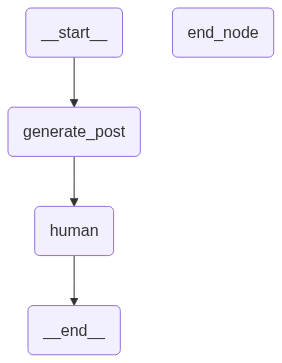

In [10]:
graph.add_edge(START,"generate_post")
graph.add_edge('generate_post','human')
graph.set_finish_point('end_node')

worflow=graph.compile(checkpointer=check)

worflow

In [11]:
thread_config = {"configurable": {
    "thread_id": uuid.uuid4()
}}

linkedin_topic = input("Enter your LinkedIn topic: ")
initial_state = {
    "topic": linkedin_topic, 
    "post": [], 
    "feedback": []
}

In [12]:
for chunk in worflow.stream(initial_state, thread_config, stream_mode="values"):
    for nodeid,values in chunk.items():

        if (nodeid=='__interrupt__'):
            while True:
                user_feedback = input("Provide feedback (or type 'done' when finished): ")

                # Resume the graph execution with the user's feedback
                worflow.invoke(Command(resume=user_feedback), config=thread_config)

                # Exit loop if user says done
                if user_feedback.lower() == "done":
                    break


Task human with path ('__pregel_pull', 'human') wrote to unknown channel branch:to:generate_post_, ignoring it.


the generated post is Here's a structured and engaging LinkedIn post about AI:

---

🚀 **AI isn't just a buzzword anymore; it's the engine driving unprecedented transformation across every industry.**

From automating routine tasks to powering groundbreaking research and personalizing customer experiences, the pace of innovation in Artificial Intelligence is staggering. It's no longer a question of *if* AI will impact your role, but *how* you'll leverage it.

For professionals and businesses, this shift presents both immense opportunities and new challenges:

*   **Opportunity:** AI amplifies human potential, freeing us to focus on higher-value, creative, and strategic tasks. It unlocks efficiencies, drives data-driven insights, and enables innovation at scale.
*   **Challenge:** The need for continuous learning, ethical considerations, and adapting to new ways of working is paramount. Understanding AI's capabilities and limitations is crucial for navigating this evolving landscape.

T

NotImplementedError: Unsupported message type: <class 'langgraph.types.Interrupt'>
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE 